# scFEA Tutorial 2

### 1. Introduction

In this tutorial, we will show how to embedding scFEA analysis into the general Seurat pipeline.


### 2. Demo
First, let's load and check original input.

In [1]:
# use rpy2 to enable R and python in one jupyter notebook
%load_ext rpy2.ipython

In [2]:
%%R
setwd('./scFEA')
gene_data <- read.csv('./input/GSE72056_full.csv', row.names = 1, header = T)
print(gene_data[1:5,1:2])

       Cy72_CD45_H02_S758_comb CY58_1_CD45_B02_S974_comb
ALDOC                 0.000000                         0
MAOA                  0.000000                         0
ASS1                519.368337                         0
AHCYL2                3.710014                         0
FUT4                  0.000000                         0


In [3]:
%%R
library(Seurat)
library(ggplot2)
obj <- CreateSeuratObject(counts = gene_data, project = "tutorial")
obj <- NormalizeData(obj, verbose = F)
all_genes <- rownames(obj)
obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000, verbose = F)
obj <- ScaleData(obj, features = all_genes, verbose = F)
obj <- RunPCA(obj, features = VariableFeatures(object = obj), verbose = F)
#DimPlot(obj, reduction = "pca") + ggtitle('PCA')

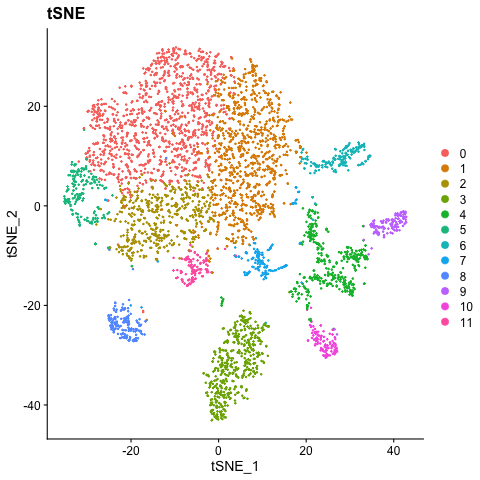

In [4]:
%%R
obj <- FindNeighbors(obj, dims = 1:10, verbose = F)
obj <- FindClusters(obj, resolution = 0.5, verbose = F)
obj <- RunTSNE(obj, dims = 1:10, verbose = F)
DimPlot(obj, reduction = "tsne") + ggtitle('tSNE')

Suppose we have finished a general Seurat analysis. We can prepare scFEA input data (gene expression) by extracting gene expression from Seurat object.

In [5]:
%%R
ExportGeneExpr <- obj@assays$RNA@counts
write.csv(ExportGeneExpr, file='./input/Seurat_geneExpr.csv', row.names = T)

In [6]:
%%bash
python src/scFEA.py --data_dir data --input_dir input \
                    --test_file Seurat_geneExpr.csv \
                    --moduleGene_file module_gene_glutaminolysis1_m23.csv \
                    --stoichiometry_matrix cmMat_glutaminolysis1_c17_m23.csv \
                    --cName_file cName_glutaminolysis1_c17_m23.csv \
                    --output_flux_file output/Seurat_gluta_flux.csv \
                    --output_balance_file output/Seurat_gluta_balance.csv

Starting load data...
Load compound name file, the balance output will have compound name.
Load data done.
Starting process data...
Process data done.
Starting train neural network...
Training time:  151.81953692436218
scFEA job finished. Check result in the desired output folder.


100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


After scFEA done, we can read results into Seurat again to perform downstream analysis.

In [8]:
%%R
predFlux <- read.csv('./output/Seurat_gluta_flux.csv', header = T, row.names = 1)
predFlux <- data.matrix(predFlux)
predFlux0 <- t(predFlux)

# add flux as a new assay
obj[["FLUX"]] <- CreateAssayObject(counts = predFlux0)

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



Change default assay to FLUX to perfom cell clustering based on metabolic flux and plot tSNE.

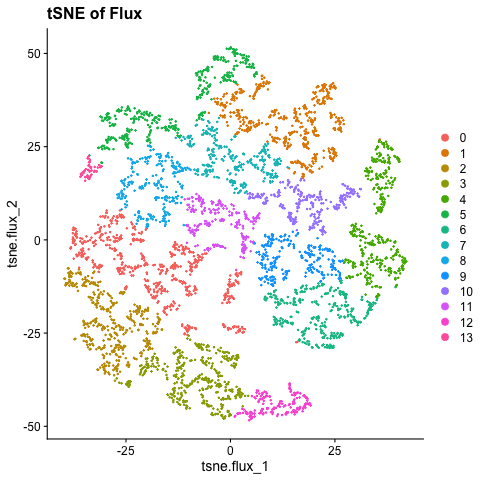

In [9]:
%%R
DefaultAssay(obj) <- 'FLUX'
obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000, verbose = F)
obj <- ScaleData(obj, features = rownames(obj), assay = 'FLUX', verbose = F)
obj <- RunPCA(obj, features = VariableFeatures(object = obj), npcs = 10, reduction.name = 'pca.flux', verbose = F)
obj <- FindNeighbors(obj, dims = 1:2, verbose = F)
obj <- FindClusters(obj, resolution = 0.5, verbose = F)
obj <- RunTSNE(obj, dims = 1:2, assay = 'FLUX', reduction.name = "tsne.flux", verbose = F)
DimPlot(obj, reduction = "tsne.flux") + ggtitle('tSNE of Flux')

Now we plot the results from both RNA-seq and metabolic flux into one figure. 

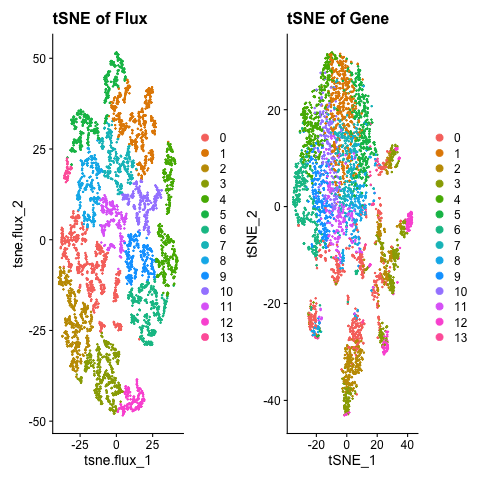

In [10]:
%%R
library(patchwork)
p1 <- DimPlot(obj, reduction = "tsne") + ggtitle('tSNE of Gene')
p2 <- DimPlot(obj, reduction = "tsne.flux") + ggtitle('tSNE of Flux')
p2 + p1

Done.